# Micrograd lecture companion notebook
Jupyter notebook with follow-along code for Andrej Karpathy's lecture at https://youtu.be/VMj-3S1tku0

This is the most step-by-step spelled-out explanation of backpropagation and training of neural networks. It only assumes basic knowledge of Python and a vague recollection of calculus from high school.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Derivative of a simple function with one input

In [2]:
def f(x): 
    return 3*x**2 - 4*x+5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange (-5, 5, 0.25)
print (xs)

ys = f(xs)
print (ys)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


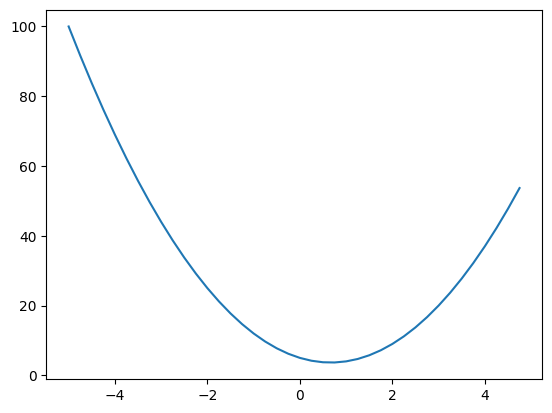

In [5]:
plt.plot(xs, ys)

In [6]:
x=2/3
h=0.0001
print ((f(x+h)-f(x))/h)

0.0002999999981767587


## Derivative of a function with multiple inputs

d1= 4.0
d2= 3.999699999999999
Slope1= -3.000000000010772
d1= 4.0
d2= 3.99990001
Slope2= -0.9998999999982772
d1= 4.0
d2= 4.00000001
Slope3= 9.99999993922529e-05


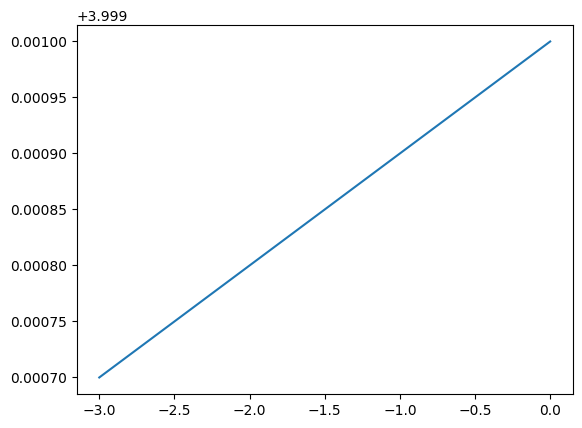

In [7]:
h=0.0001
slopes = [0,1,2]
ds = [0,1,2]

#inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
a += h
ds[0] = a*b + c

slopes[0] = (ds[0]-d1)/h

print ("d1=", d1)
print ("d2=", ds[0])
print ("Slope1=", slopes[0])

b += h
ds[1] = a*b + c

slopes[1]  = (ds[1]-d1)/h
print ("d1=", d1)
print ("d2=", ds[1])
print ("Slope2=", slopes[1])

c+= h
ds[2] = a*b + c

slopes[2]  = (ds[2]-d1)/h
print ("d1=", d1)
print ("d2=", ds[2])
print ("Slope3=", slopes[2])

plt.plot(slopes,ds)



## Starting the core Value object of micrograd and its visualization

In [8]:
import math


class Value:
    """ stores a single scalar value and its gradient """
    
    def __init__(self, data,_children=(), _op="", label=""):
       self.data = data
       self.grad = 0.0
       self._prev = set(_children)
       self._op = _op
       self.label=label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), '/')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        return Value(t, (self, ), 'tanh')
    


In [2]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root,format='svg', rankdir='LR'):
    
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

## Manual backpropagation example #1: simple expression

Value(data=-8.0)


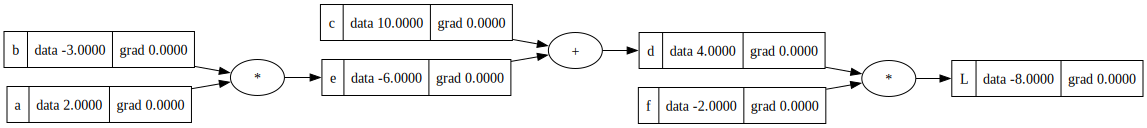

In [10]:
# Let's build our nodes expressions for a simple Loss function (L)
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value (-2.0, label='f')
L = d * f
L.label = 'L'

#print the data
print (L)
#Plot the graph
draw_dot(L)

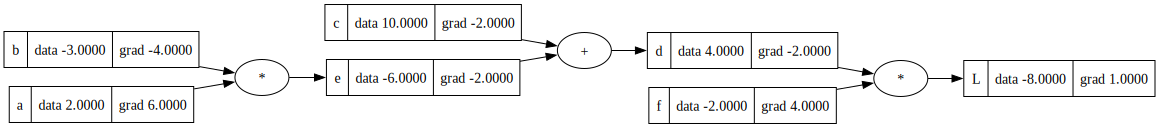

In [11]:
# Manually compute the gradients working backwards from L

L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0

# Redraw the graph with the gradients
draw_dot(L)


Value(data=-7.4352)


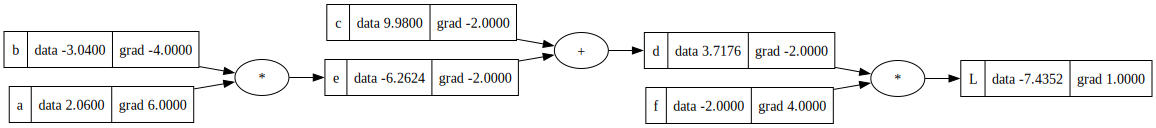

In [12]:
# Manual data changes and forward pass

# Nudge the lead node in the direction of the gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

#rerun the forward pass
e = a * b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value (-2.0, label='f')
L = d * f
L.label = 'L'

# restore the manual assigned gradients
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0

# Loss (L) reduces aka becomes "less negative" / moves to zero aka improves
# Before: -8.0, After: -7.xx
print (L)
draw_dot(L)

## The TANH function
The hyperbolic tangent function, often denoted as tanh, is a mathematical function that maps its input to a range between -1 and 1. In the context of machine learning, the tanh function is commonly used as an activation function in neural networks. Here are some reasons why the tanh function is useful in machine learning:

**Squashing Input Range**

The tanh function squashes its input values to the range of [-1, 1]. This can be beneficial for the numerical stability of the model, especially when dealing with neural networks with multiple layers. It helps to keep the activations within a manageable range, preventing issues like vanishing or exploding gradients during training.

**Zero-Centered Output**

Unlike the sigmoid function, which maps inputs to the range [0, 1], the tanh function maps inputs to the range [-1, 1]. This makes the output of the tanh function zero-centered. Zero-centered activations can help in learning more efficiently, as positive and negative values provide a balanced update direction for the weights during back propagation.

**Gradients and Derivatives**

The tanh function has steeper gradients in comparison to the sigmoid function. Steeper gradients can accelerate learning in the network, as weight updates during back propagation are more pronounced. This can lead to faster convergence during training.
Similarity to Sigmoid:

**Capturing Negative and Positive Relationships**

The tanh function captures both negative and positive relationships in the data. This can be advantageous in scenarios where the input data may have both positive and negative values, as the tanh function can model relationships on both sides of zero.


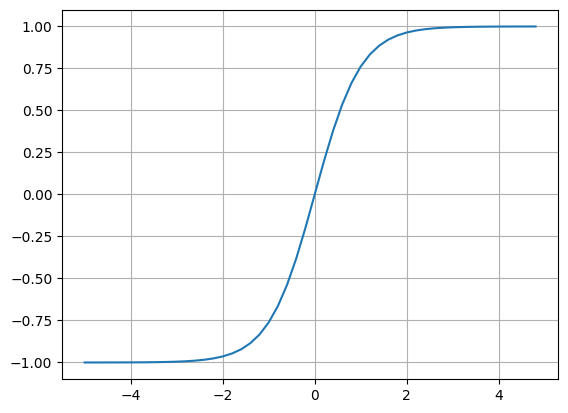

In [13]:
# Plot the tanh function as an example
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

## Manual backpropagation example #2: a neuron
Compare [the drawing of a neuron in our brains](https://cs231n.github.io/assets/nn1/neuron.png) with the [mathematical representation](https://cs231n.github.io/assets/nn1/neuron_model.jpeg).

In the following sections, we will write the code to simulate the neuron's working.

### The summation function

We will start with coding the Summation function ("Cell body") shown in the [mathematical representation](https://cs231n.github.io/assets/nn1/neuron_model.jpeg).

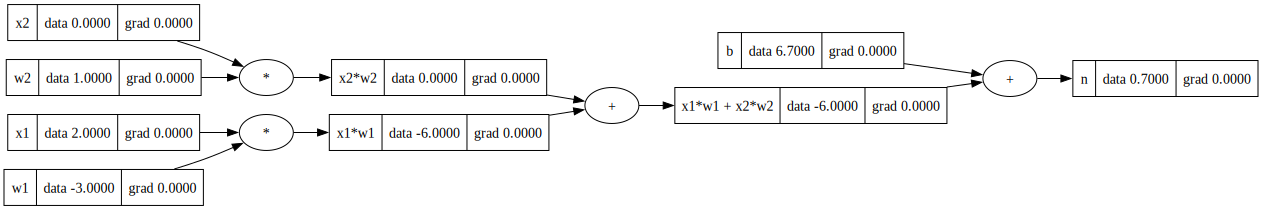

In [14]:
# inputs x1 and x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# weights w1 and w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# bias of the neuron
b = Value(6.7,label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

#graph out the expression
draw_dot(n)

### The output function
Now we use the tanh as the output function of the neuron shown in the [mathematical representation](https://cs231n.github.io/assets/nn1/neuron_model.jpeg).

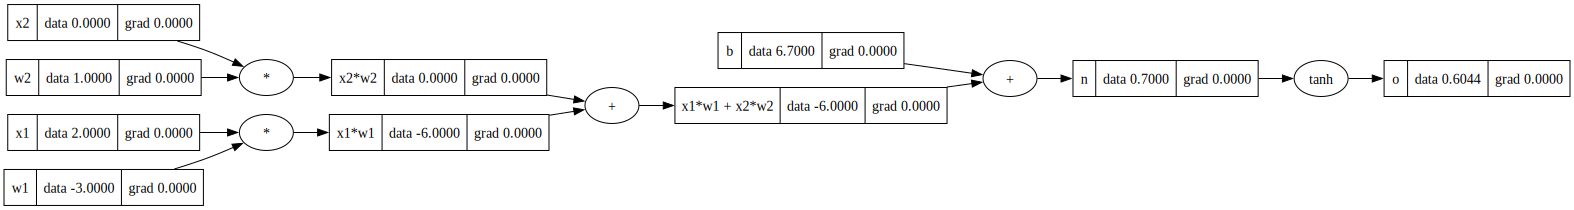

In [15]:
#graph out the output of the neuron
o = n.tanh()
o.label = 'o'
draw_dot(o)

Let's use a special value for the bias.

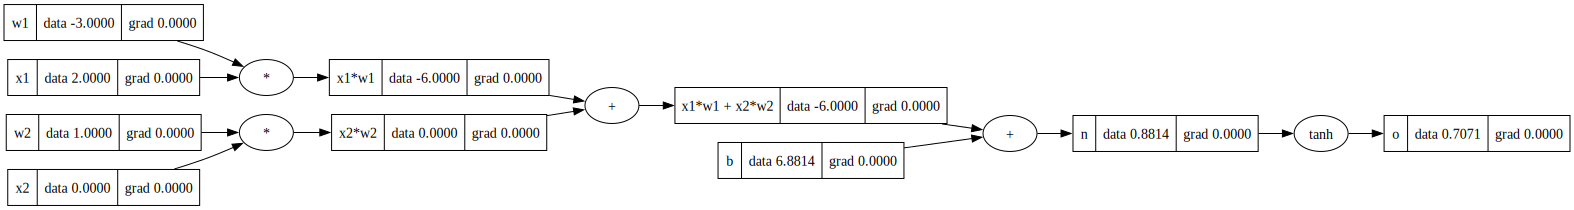

In [17]:
# inputs x1 and x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# weights w1 and w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# inputs x1 and x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# weights w1 and w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# bias of the neuron - special value to make numbers easier to work with
b = Value(6.8813735870,label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

#graph out the output of the neuron
o = n.tanh()
o.label = 'o'
draw_dot(o)

### Manual back propagation
Let's proceed to manually assign gradients starting from right (output) to the left (inputs)

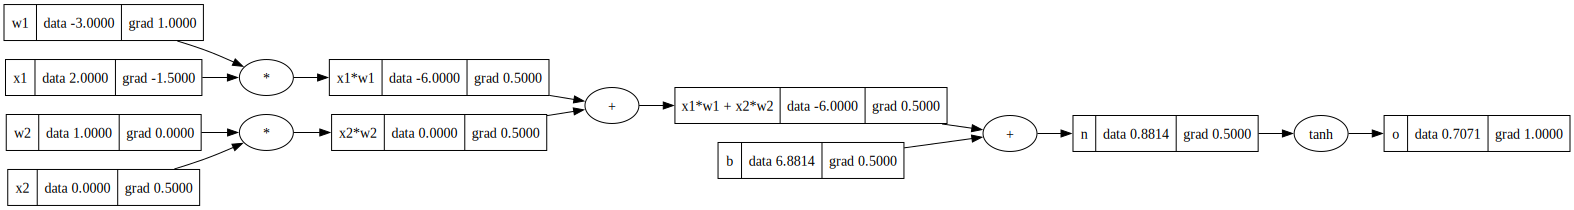

In [18]:
# Manually compute the gradients working backwards from L
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5

b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

# plo it
draw_dot(o)



## Automated back propagation
We saw how manual propagation can get tedious as the mathematical expressions get more complex. We now see how to enable automated back propagation.

### Add the _backward code to the Value class

***NOTE: All further updates to the Value class will be made to this snippet so the code you see here is a cumulative update.***

Let's add the "backward" function to each operation to flow the computations back automatically.


In [3]:
import math

class Value:
    """ stores a single scalar value and its gradient """
    
    def __init__(self, data,_children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label=label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
       
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
            
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

        build_topo(self)

        self.grad = 1.0 # start gradient with 1.0 (base case)
        # go one variable at a time and apply the chain rule to get its gradient
        for v in reversed(topo):
            v._backward()

    def exp (self):
        out = Value(math.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __neg__(self): # -self
        return self * -1



### Re-initialize without any gradient values (gradient = 0)

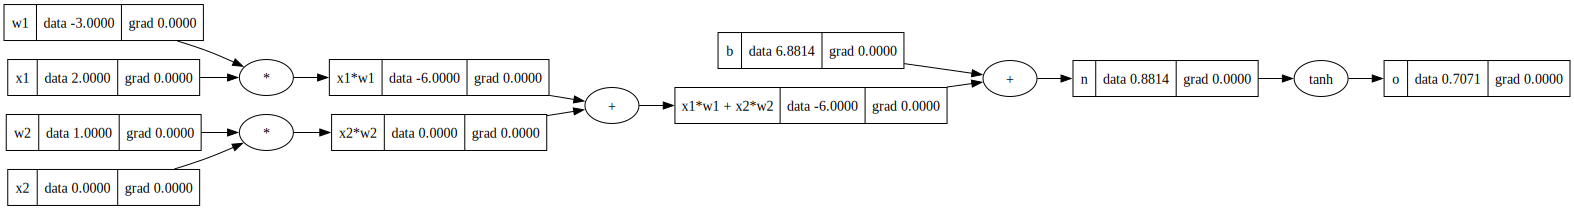

In [20]:
# inputs x1 and x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# weights w1 and w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# bias of the neuron - special value to make numbers easier to work with
b = Value(6.8813735870,label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

#graph out the output of the neuron
o = n.tanh()
o.label = 'o'
draw_dot(o)

### Call the _backward function for "semi-automated" back propagation

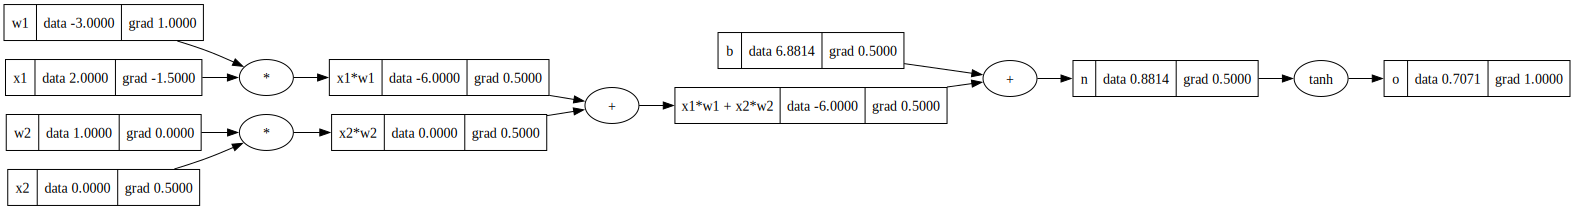

In [21]:
o.grad = 1.0 # start gradient with 1.0 (base case)
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

### Topological sort - organize for full automation

Note the updated "VALUE" class with a new method called "backward()" at the class level.

In [22]:
def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

        build_topo(self)

        self.grad = 1.0 # start gradient with 1.0 (base case)
        # go one variable at a time and apply the chain rule to get its gradient
        for node in reversed(topo):
            node._backward()
        

Re-initialize our neuron with zero gradients

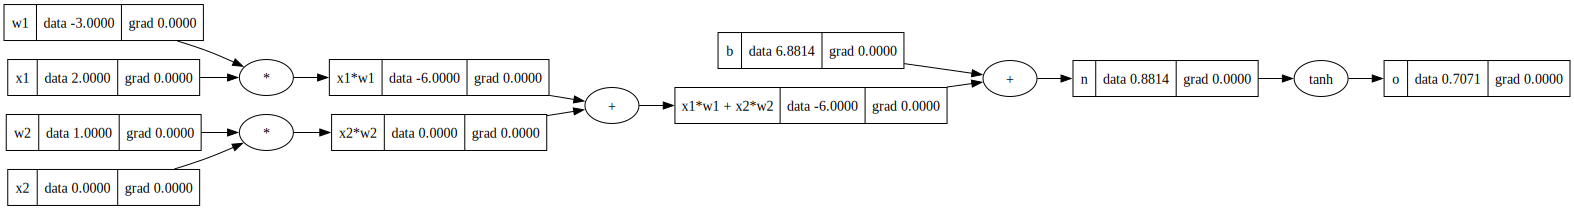

In [23]:
# inputs x1 and x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# weights w1 and w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# bias of the neuron - special value to make numbers easier to work with
b = Value(6.8813735870,label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

#graph out the output of the neuron
o = n.tanh()
o.label = 'o'
draw_dot(o)

Call the "backward" method on the last "Output" node, 'o' to loop through the backward propagation.

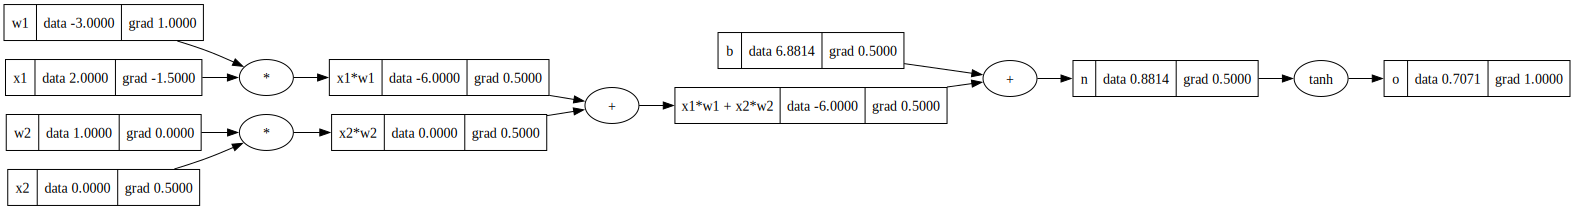

In [24]:
# Backpropagate gradients through the graph starting from o
o.backward()

# plot it
draw_dot(o)

# Test for back propagation fix

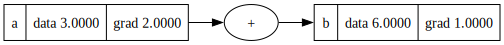

In [25]:
a = Value (3.0,label='a')

# In the graph, both 'a's point to 'b'
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)

# Confirm that the gradients are correct
# (should be 2.0 for both a's) and it is.

# Thanks to this line of code in the __add__ method of the Value class:
# def _backward():
    # self.grad += out.grad
    # other.grad += out.grad

## Breaking up a tanh, exercising with more operations

### Supporting more operations

In [26]:
# After adding this line in the Value:add method
# > other = other if isinstance(other, Value) else Value(other)
a = Value (3.0,label='a')
print ("a = ", a)
a += 1
print ("a = a + 1 = ",a)

a = a * 3
print ("a = a * 3 = ",a)

a = a/2
print ("a = a / 2 = ", a)

print ("1 + a = ", 1 + a)
print ("2 * a = ", 2 * a)


a =  Value(data=3.0)
a = a + 1 =  Value(data=4.0)
a = a * 3 =  Value(data=12.0)
a = a / 2 =  Value(data=6.0)
1 + a =  Value(data=7.0)
2 * a =  Value(data=12.0)


### Breaking up the tanh node

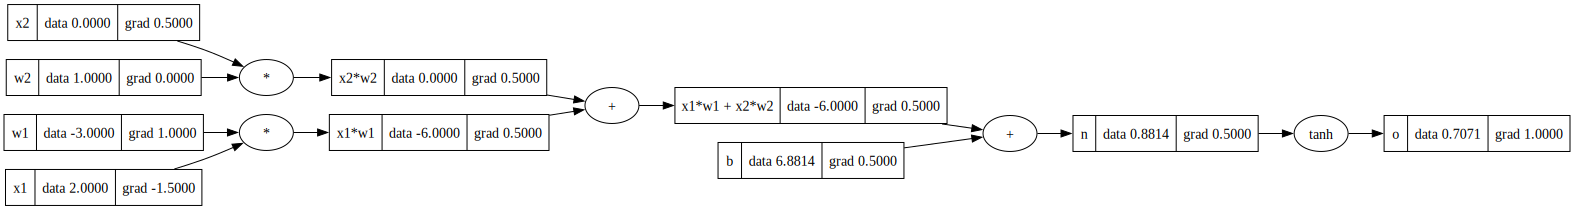

In [47]:
# inputs x1 and x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# weights w1 and w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# bias of the neuron - special value to make numbers easier to work with
b = Value(6.8813735870,label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

o.backward()
draw_dot(o)

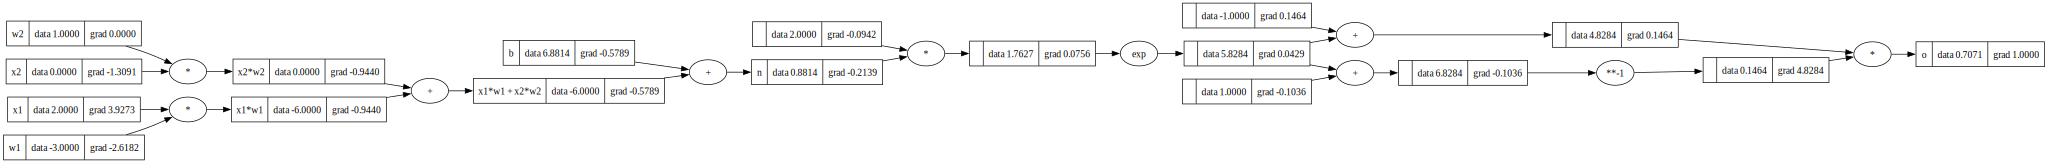

In [53]:
# inputs x1 and x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# weights w1 and w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# bias of the neuron - special value to make numbers easier to work with
b = Value(6.8813735870,label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

#change out the tanh line "o = n.tanh()" with expanded expression thanks to the exp operator we added to the Value class
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

## Same thing in Pytorch for comparison

In [54]:
import torch

In [94]:
x1 = torch.tensor(2.0,requires_grad=True).double()
x2 = torch.tensor(0.0,requires_grad=True).double()
w1 = torch.tensor(-3.0,requires_grad=True).double()
w2 = torch.tensor(1.0,requires_grad=True).double()
b = torch.tensor(6.8813735870,requires_grad=True).double()

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.retain_grad()
n.retain_grad()
b.retain_grad()
w2.retain_grad()
w1.retain_grad()
x2.retain_grad()
x1.retain_grad()

o.backward()

print ("x1:", x1.data.item(), " grad:" , x1.grad.data.item())
print ("x2:", x2.data.item(), " grad:" , x2.grad.data.item())
print ("w1:", w1.data.item(), " grad:" , w1.grad.data.item())
print ("w2:", w2.data.item(), " grad:" , w2.grad.data.item())
print ("b:", b.data.item(), " grad:" , b.grad.data.item())
print ("n:", n.data.item(), " grad:" , n.grad.data.item())
print ("o:", o.data.item(), " grad:" , o.grad.data.item())



x1: 2.0  grad: -1.5000003851533106
x2: 0.0  grad: 0.5000001283844369
w1: -3.0  grad: 1.0000002567688737
w2: 1.0  grad: 0.0
b: 6.881373405456543  grad: 0.5000001283844369
n: 0.881373405456543  grad: 0.5000001283844369
o: 0.7071066904050358  grad: 1.0


## Building out a neural net library in micrograd

In [4]:
import torch
import random

### Let's make a Neuron class- the lowest unit

In [5]:
class Neuron:
    def __init__(self,inputs):
        self.weights = [Value(random.uniform(-1,1)) for _ in range(inputs)]
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.weights, x)), self.bias)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.weights + [self.bias]

# Define a two-dimensional Neuron and get its output for a given input
x = [2.0,3.0]
 # 2 dimensional neuron
n = Neuron (2)
# output of the neuron
n(x) 

Value(data=0.21302965484197162)

### Next up, a Layer class composed of Neurons
For example, you can have a layer composed of several independent neurons.

In [6]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
# two-dimensional neuron
x = [2.0, 3.0] 
# 3 neurons in the layer
L = Layer(2, 3) 
# 3 outputs from the layer
L(x) 

[Value(data=0.9991764877472769),
 Value(data=-0.9997229140026159),
 Value(data=0.8586039527139645)]

### Finally, a Muti-Layer Perceptron (MLP) class
MLP is composed of multiple layers connected to each other and each Layer is composed of independent neurons.

In [7]:
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# three-dimensional input
x = [2.0, 3.0, -1.0] 
# MLP with an input layer with 3 neurons, two hidden layers with 4 neurons each, and an output layer with 1 neuron
mlp = MLP(3, [4, 4, 1]) 
# output of the MLP
mlp(x)

Value(data=0.8867745145402711)

In [8]:
print (len(mlp.parameters()),"parameters:")
mlp.parameters()

41 parameters:


[Value(data=-0.6992772533256784),
 Value(data=-0.42489388289370145),
 Value(data=0.7083384713415004),
 Value(data=0.3314815153104391),
 Value(data=0.19185100635637076),
 Value(data=0.2743745874517691),
 Value(data=0.2180996760017473),
 Value(data=0.7860026186678093),
 Value(data=-0.45917653037658934),
 Value(data=0.30639973715427526),
 Value(data=0.18008337685130682),
 Value(data=-0.11887669161867498),
 Value(data=0.7577772454310971),
 Value(data=0.8802176635964041),
 Value(data=0.7417303041644963),
 Value(data=0.6496000090853806),
 Value(data=0.29622103327795535),
 Value(data=0.3705590918583648),
 Value(data=-0.6381396190044333),
 Value(data=-0.7206506584251338),
 Value(data=0.7309086438587795),
 Value(data=0.9752212651990897),
 Value(data=-0.0723442055396124),
 Value(data=0.8178698768202595),
 Value(data=0.8976869219888104),
 Value(data=-0.6745973624168624),
 Value(data=0.057319798190236915),
 Value(data=-0.17213094113929728),
 Value(data=-0.7156719867123975),
 Value(data=-0.28206473

### Visualize the MLP

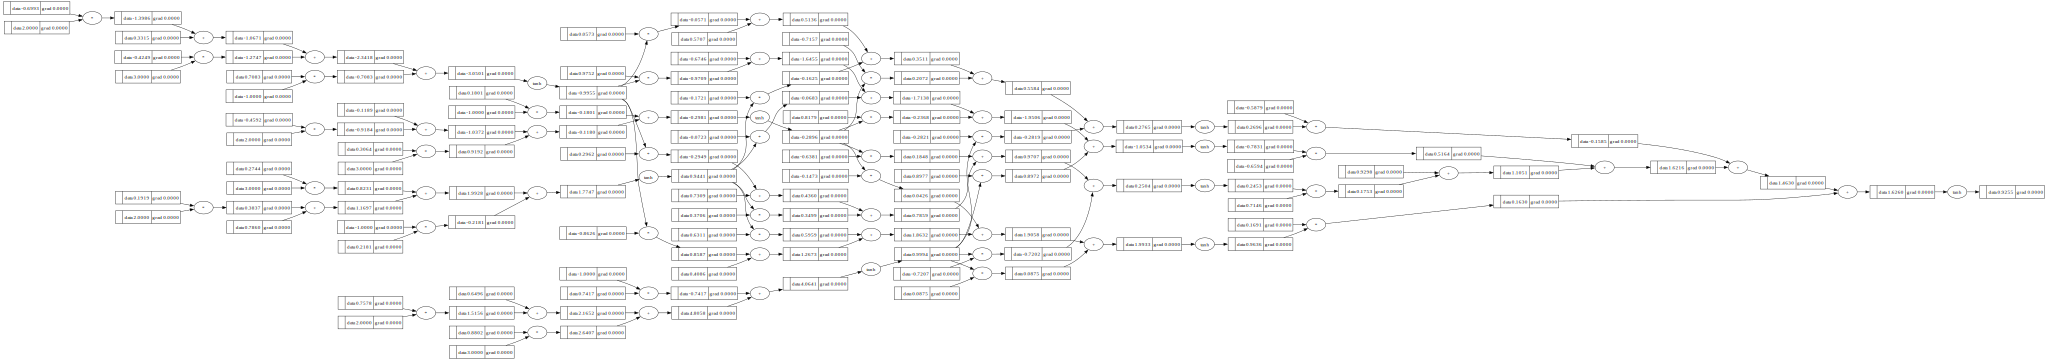

In [9]:
draw_dot(mlp(x))

### Apply the MLP to a simple prediction problem.

In [10]:
# Define four sets of inputs, each with three values to use for predicting the desired target.
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
# desired target values, one for each input set
ys = [1.0, -1.0, -1.0, 1.0]

# check default prediction
ypred = [mlp(x) for x in xs]

# compare predictions with targets - we want them to be 1.0, -1.0, -1.0, 1.0 based on the ys set.
ypred
# Hint the predictions are not even close to the desired targets


[Value(data=0.9254883248603548),
 Value(data=0.9376597975161269),
 Value(data=0.7287448229233932),
 Value(data=0.9270291089389393)]

## Write the Loss function and iterate one-time to validate 
Clearly the predictions are way off the desired targets.

The next step is to have one number aka the "Loss" and write code for computing it.

In [11]:
# Define a loss function that takes the predictions and targets and returns the sum of the squared differences between them.
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
loss

Value(data=6.753960894369033)

In [12]:
loss.backward()

In [13]:
mlp.layers[0].neurons[0].weights[0].grad
# Its a negative gradient meaning that if we increase the weight, the loss will decrease.

-9.831378698586855

In [14]:
mlp.layers[0].neurons[0].weights[0].data
# its a positive weight with a negative gradient meaning that if we increase the weight, the loss will decrease.

-0.6992772533256784

In [15]:
# Let's update the weights using gradient descent to slightly increase the weight to decrease the loss.
for p in mlp.parameters():
  p.data += -0.01 * p.grad

Let's confirm that the Loss has indeed reduced from the previous value.

In [16]:
# check default prediction
ypred = [mlp(x) for x in xs]
# Define a loss function that takes the predictions and targets and returns the sum of the squared differences between them.
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
loss
# Confirm that the loss has decreased (new 6.78.. < old 6.96...)

Value(data=6.138263499779014)

## Manually iterate to reduce the loss and approach the desired targets

Steps: Forward pass -> backward pass -> Nudge ...iterate until:
- Loss = near zero and targets = close to desired

Desired target values, one for each input set:
ys = [1.0, -1.0, -1.0, 1.0]

In [154]:
# check default predictions to begin with
ypred = [mlp(x) for x in xs]
# Define a loss function that takes the predictions and targets and returns the sum of the squared differences between them.
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
print ("Loss = ", loss)
# Confirm that the loss has decreased - we stop at near zero loss

Loss =  Value(data=0.007068866583479743)


In [155]:
# Check the predictions - are they closer to the targets?
ypred
# We stopped at Loss near zero and our target values very close to desired values.

[Value(data=0.9705591079601559),
 Value(data=-0.9517856145990766),
 Value(data=-0.9419112940646773),
 Value(data=0.9775684208636837)]

In [152]:
# Backward pass to update the gradients
loss.backward()

In [153]:
# Let's nudge the data in the direction of the gradients to decrease the loss
for p in mlp.parameters():
  p.data += -0.001 * p.grad

## Automate the "training" iteration (forward->backward-nudge)

In [10]:
# Define four sets of inputs, each with three values to use for predicting the desired target.
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
# desired target values, one for each input set
ys = [1.0, -1.0, -1.0, 1.0]

# check default prediction
ypred = [mlp(x) for x in xs]

# compare predictions with targets - we want them to be 1.0, -1.0, -1.0, 1.0 based on the ys set.
ypred
# Hint the predictions are not even close to the desired targets

[Value(data=0.8867745145402711),
 Value(data=0.8705964842907743),
 Value(data=0.8696660555785559),
 Value(data=0.9172050149328634)]

In [14]:
for k in range(20):
  
  # forward pass
  ypred = [mlp(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in mlp.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

print (ypred)
  

0 7.01445738653354
1 5.755908699236766
2 2.608310775665895
3 1.3065224775632065
4 0.7914586353983972
5 0.4747850906277137
6 0.1350565320790056
7 0.09605117512723862
8 0.07537422519091827
9 0.05743919767639474
10 0.046977185963467
11 0.0400262931694574
12 0.035832675147343694
13 0.03187529823439457
14 0.02831546523504493
15 0.02596683491433964
16 0.023220154391862476
17 0.02111995010885568
18 0.01949440313760005
19 0.017822614408823018
[Value(data=0.9461012710873443), Value(data=-0.9348951026108959), Value(data=-0.9305292075502322), Value(data=0.9234970408233866)]


In [1]:
print ("That's it folks. Thanks to @karpathy for the inspiration. Happy 2024!")

That's it folks. Thanks to @karpathy for the inspiration. Happy 2024!
